In [3]:
import argparse
import json
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm, LinearSegmentedColormap  # NEW
from matplotlib import cm  # NEW
from matplotlib.colors import TwoSlopeNorm  # NEW
import re
import os
from matplotlib.transforms import ScaledTranslation



In [ ]:
def load_jsonl(path: str) -> pd.DataFrame:
    df = pd.read_json(path, lines=True)
    assert {"gt", "top_ids", "top_probs"}.issubset(df.columns), \
        "Input must have keys: gt, top_ids, top_probs"
    # Convert top_probs to float if it's a string
    if df["top_probs"].dtype == object:
        df["top_probs"] = df["top_probs"].apply(lambda x: [float(p) for p in x])
    return df

def print_last_k_lists(acc: np.ndarray, labels: List[str], support: np.ndarray, thresholds=(0.10, 0.05, 0.01)):
    """
    For each bin (row), find the largest rank k with correctness > threshold.
    Prints three lists (one per threshold), ordered from highest top1 bin (e.g., 0.9–1.0) to lowest.
    If no rank exceeds the threshold, returns 0 for that row.
    """
    def right_edge(label: str) -> float:
        # Strip any appended " (n=...)" part
        base = label.split("(")[0].strip()
        # Accept en-dash or hyphen
        sep = "–" if "–" in base else "-"
        parts = [p.strip() for p in base.split(sep)]
        try:
            return float(parts[-1])
        except Exception:
            nums = re.findall(r"[-+]?\d*\.\d+|\d+", base)
            return float(nums[-1]) if nums else np.nan

    rights = np.array([right_edge(s) for s in labels])
    # Order rows by descending right edge so first is ~0.9–1.0
    order = np.argsort(rights)[::-1]

    for thr in thresholds:
        result = []
        for b in order:
            row = acc[b, :]
            mask = (~np.isnan(row)) & (row > thr)
            idxs = np.flatnonzero(mask)
            if support[b] < 10:  # NEW: require at least 100 samples in this row
                result.append(1)
                continue
            result.append(max(1, int(idxs[-1] + 1) if idxs.size > 0 else 0))  # CHANGED: enforce minimum of 1
        print(f"last_top_k_where_c_gt_{thr:.2f} = [{','.join(map(str, result))}]")

def make_bins_top1(
    top1: np.ndarray,
    bins: int = 10,
    quantile: bool = False,
) -> Tuple[np.ndarray, List[str], np.ndarray]:
    if quantile:
        cat = pd.qcut(top1, q=bins, duplicates="drop")
        codes = cat.cat.codes.to_numpy()
        intervals = cat.cat.categories
        labels = [f"{iv.left:.2f}–{iv.right:.2f}" for iv in intervals]
        edges = np.array([iv.left for iv in intervals] + [intervals[-1].right])
        return codes, labels, edges
    else:
        edges = np.linspace(0.0, 1.0, bins + 1)
        codes = np.digitize(top1, edges, right=True) - 1
        codes = np.clip(codes, 0, bins - 1)
        labels = [f"({edges[i]:.1f},{edges[i+1]:.1f}]" for i in range(bins)]
        return codes, labels, edges


def aggregate_rank_by_bin_conditional(
    df: pd.DataFrame,
    K: int,
    bins: int = 10,
    quantile_bins: bool = False,
):
    """
    Computes:
      acc[b, r]      = \bar c_{m,r}  = P(gold at rank r | bin b)
      mu_cond[b, r]  = \tilde p_{m,r}= E[p^(r) | bin b, gold at rank r]   <-- conditional mean
      std_cond[b, r] = std of p^(r) over the same conditional subset
      (also returns unconditional means for reference)
      C_topK[b]      = sum_r mu_cond[b,r] * acc[b,r]  (bin accuracy restricted to gold ∈ top-K)
    """
    top_ids = np.stack(df["top_ids"].to_numpy())
    top_probs = np.stack(df["top_probs"].to_numpy())
    assert top_ids.shape == top_probs.shape, "top_ids/top_probs shape mismatch"

    if K > top_probs.shape[1]:
        raise ValueError(f"K={K} > available top list length {top_probs.shape[1]}")

    top_ids = top_ids[:, :K]
    top_probs = top_probs[:, :K]
    top1 = top_probs[:, 0]
    gt = df["gt"].to_numpy()

    codes, labels, _ = make_bins_top1(top1, bins=bins, quantile=quantile_bins)
    B = len(labels)

    # rank-wise correctness (same as your current acc)
    acc = np.full((B, K), np.nan)          # \bar c_{m,r}
    support = np.zeros(B, dtype=int)       # N_m

    # NEW: conditional means (tilde p), and also keep unconditional for reference
    mu_cond = np.full((B, K), np.nan)      # \tilde p_{m,r}
    std_cond = np.full((B, K), np.nan)
    mu_uncond = np.full((B, K), np.nan)    # \bar p_{m,r}
    std_uncond = np.full((B, K), np.nan)

    # Optional: counts per (bin, rank) where gold is at rank r
    N_mr = np.zeros((B, K), dtype=int)

    for b in range(B):
        idx = (codes == b)
        n = int(idx.sum())
        support[b] = n
        if n == 0:
            continue

        probs_b = top_probs[idx, :]      # [n, K]
        ids_b = top_ids[idx, :]          # [n, K]
        gt_b = gt[idx]                   # [n]

        # Unconditional means (what you had before)
        mu_uncond[b, :] = probs_b.mean(axis=0)
        std_uncond[b, :] = probs_b.std(axis=0, ddof=0)

        # Rank-wise correctness and counts
        # mask[t, r] == True iff gold is at rank r for example t
        mask = (ids_b == gt_b[:, None])  # [n, K] bool
        counts = mask.sum(axis=0)        # [K]
        N_mr[b, :] = counts
        acc[b, :] = counts / n

        # CONDITIONAL means: average p^(r) ONLY over examples where gold is at rank r
        for r in range(K):
            if counts[r] > 0:
                vals = probs_b[mask[:, r], r]   # select p^(r) where gold-at-r
                mu_cond[b, r] = vals.mean()
                std_cond[b, r] = vals.std(ddof=0)
            else:
                # leave as NaN; contribution to sums will be zero because acc[b,r]=0
                pass

    # Bin accuracy restricted to top-K (sanity check / proxy):
    # C_topK[b] = sum_r \tilde p_{m,r} * \bar c_{m,r}
    C_topK = np.nansum(mu_cond * acc, axis=1)  # shape [B]

    return (
        acc,            # \bar c_{m,r}
        mu_cond,        # \tilde p_{m,r}  (use this for conditioned calculations)
        std_cond,
        support,
        labels,
        # extras (optional, but handy to inspect)
        mu_uncond,      # \bar p_{m,r}    (your previous "mu")
        std_uncond,
        N_mr,
        C_topK
    )

def plot_heatmap(
    acc: np.ndarray,
    mu: np.ndarray,
    support: np.ndarray,
    labels: List[str],
    K: int,
    title: str = "",
    save_path: str = None,
):
    acc_plot = acc[:, :K]
    mu_plot = mu[:, :K]
    prod_plot = mu_plot * acc_plot

    B = acc_plot.shape[0]
    fig_w = 9.0   # a bit wider to fit 3-line annotations
    fig_h = 6.0
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    # Color = mu * c
    prod = mu * acc  # elementwise product; NaNs propagate if any input is NaN
    norm = PowerNorm(gamma=0.5, vmin=0.0, vmax=1.0)  # NEW: more contrast below 0.1
    viridis = cm.get_cmap("viridis")  # NEW
    mid = viridis(0.5)                # NEW
    high = viridis(1.0)               # NEW
    new_cmap = LinearSegmentedColormap.from_list("powderblue_to_viridis", ["#E0F2FE", mid, high])  # CHANGED

    #im = ax.imshow(prod, origin="lower", aspect="auto", norm=norm, cmap=new_cmap)  # CHANGED
    im = ax.imshow(acc_plot, origin="lower", aspect="auto", norm=norm, cmap=new_cmap)
    cbar = fig.colorbar(im, ax=ax, pad=0.01)
    #cbar.set_label("Color: μ × c (PowerNorm γ=0.5)", rotation=90)  # CHANGED
    cbar.set_label("Correctness (c)", rotation=90)

    ax.set_xlabel("Rank")
    ax.set_ylabel("Confidence bin")
    ax.set_xticks(np.arange(K))
    ax.set_xticklabels([str(r) for r in range(1, K + 1)])

    f = [i / sum(support) for i in support]
    yticklabels = [f"{labels[b]}  {f[b]*100:.2f}%" for b in range(B)]
    ax.set_yticks(np.arange(B))
    ax.set_yticklabels(yticklabels)
    ax.set_title(title)

    # Per-cell text: mu=..., c=..., mu*c=... (all to 4 dp)
    for b in range(B):
        for r in range(K):
            m = mu_plot[b, r]
            c = acc_plot[b, r]
            if np.isnan(m) or np.isnan(c):
                continue
            mc = m * c
            txt = (
                f" \n"
    f"$\hat p$={m:.3f}\n"
    f"$\hat c$={c:.3f}\n"
)
            ax.text(r, b, txt, ha="center", va="center", fontsize=8)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=220, bbox_inches="tight")
        print(f"Saved heatmap to {save_path}")
    else:
        plt.show()
model_name="qwen2.5-32b-ins"
dataset_name="gsm8k"
trace_path = os.getenv("TOPK_TRACES_PATH", "topk_traces.jsonl")
df = load_jsonl(trace_path)
acc, mu_cond, std_cond, support, labels, mu_uncond, std_uncond, N_mr, C_topK = aggregate_rank_by_bin_conditional(
    df, K=20, bins=10, quantile_bins=False
)
#print_last_k_lists(acc, labels, support, thresholds=(0.1, 0.05, 0.01))
print_last_k_lists(acc, labels, support, thresholds=(0.01,0.03,0.05,0.07,0.09,0.1))
frequency = [i/sum(support) for i in support]
print(frequency)
cal_dir = os.getenv("CALIBRATION_DIR", ".")
plot_heatmap(
    acc, mu_uncond, support, labels, K=10,
    save_path=f"{cal_dir}/{model_name}-{dataset_name}.pdf"
)


-1.1650,0.5376


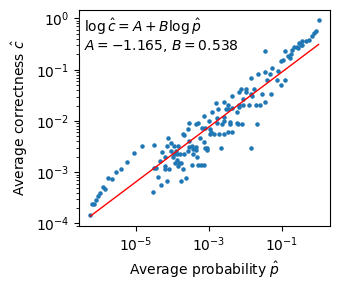

Unweighted fit loss (log-space): SSE=76.7528, MSE=0.495179, RMSE=0.70369


In [5]:
# x,y > 0 required for log
x = mu_uncond.ravel()
y = acc.ravel()
m = (x > 0) & (y > 0) & np.isfinite(x) & np.isfinite(y)
x, y = x[m], y[m]

# fit in log space: log y = A + B log x
X = np.log(x)
Y = np.log(y)
# frequency[b] = support[b] / sum(support)
freq = np.asarray([i / np.sum(support) for i in support], dtype=float)   # shape [B]
Bbins, Kcols = acc.shape
w_full = np.repeat(freq[:, None], Kcols, axis=1).ravel()                  # shape [B*K]
w = w_full[m]  
B, A = np.polyfit(X, Y, 1, w=np.sqrt(w))
B, A = np.polyfit(X, Y, 1)   # slope B, intercept A
print(f"{A:.4f},{B:.4f}")
# line in data space
xx = np.logspace(np.log10(x.min()), np.log10(x.max()), 200)
yy = np.exp(A) * xx**B

fig, ax = plt.subplots(figsize=(3.5, 3))
ax.scatter(x, y, s=5)
ax.set_xscale("log"); ax.set_yscale("log")
#ax.set_xlim(1e-5, 1)
#ax.set_ylim(1e-5, 1)
#ax.set_xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])
#ax.set_yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax.plot(xx, yy, color='red', linestyle='solid', linewidth=1)  # Changed to black dotted lineax.set_xscale("log"); ax.set_yscale("log")

cal_x_min = max(x.min(), 1e-12)
cal_x_max = min(x.max(), 1.0)
xx_cal = np.logspace(np.log10(cal_x_min), np.log10(cal_x_max), 200)
#ax.plot(xx_cal, xx_cal, linestyle='--', linewidth=1, label=r'perfect: $\hat{c}=\hat{p}$')

ax.set_xlabel(r"Average probability $\hat{p}$")
ax.set_ylabel(r"Average correctness $\hat{c}$")
ax.text(0.02, 0.97,
        rf"$\log\hat{{c}} = A + B\log\hat{{p}}$",
        transform=ax.transAxes, ha="left", va="top",
        fontsize=10, bbox=dict(boxstyle="round", facecolor="white", alpha=0.8, lw=0))
ax.text(0.02, 0.87,
        rf"$A={A:.3f}$, $B={B:.3f}$",
        transform=ax.transAxes, ha="left", va="top",
        fontsize=10, bbox=dict(boxstyle="round", facecolor="white", alpha=0.8, lw=0))
plt.savefig(f'/calibration_grids/{model_name}-{dataset_name}-scatter.pdf', dpi=300, bbox_inches='tight')
#ax.set_aspect('equal', adjustable='box')
plt.tight_layout(); plt.show()
yhat = A + B * X
resid = Y - yhat
w_eff = w  # effective weights

#SSE = np.sum(w_eff * resid**2)              # weighted sum of squared errors
#MSE = SSE / np.sum(w_eff)                   # weighted mean squared error
#RMSE = np.sqrt(MSE)
#print(f"Weighted fit loss (log-space): SSE={SSE:.6g}, MSE={MSE:.6g}, RMSE={RMSE:.6g}")
SSE_unw = np.sum(resid**2)
MSE_unw = SSE_unw / resid.size
RMSE_unw = np.sqrt(MSE_unw)
print(f"Unweighted fit loss (log-space): SSE={SSE_unw:.6g}, MSE={MSE_unw:.6g}, RMSE={RMSE_unw:.6g}")


In [ ]:
def make_bins_top1(
    top1: np.ndarray,
    bins: int = 10,
    quantile: bool = False,
) -> Tuple[np.ndarray, List[str], np.ndarray]:
    if quantile:
        cat = pd.qcut(top1, q=bins, duplicates="drop")
        codes = cat.cat.codes.to_numpy()
        intervals = cat.cat.categories
        labels = [f"{iv.left:.1f}–{iv.right:.1f}" for iv in intervals]
        edges = np.array([iv.left for iv in intervals] + [intervals[-1].right])
        return codes, labels, edges
    else:
        edges = np.linspace(0.0, 1.0, bins + 1)  # with bins=5 => 0.0,0.2,...,1.0
        codes = np.digitize(top1, edges, right=True) - 1
        codes = np.clip(codes, 0, bins - 1)
        labels = [f"{edges[i]:.1f}–{edges[i+1]:.1f}" for i in range(bins)]
        return codes, labels, edges
def plot_heatmap(
    acc: np.ndarray,
    mu: np.ndarray,
    support: np.ndarray,
    labels: List[str],
    K: int,
    title: str = "",
    save_path: str = None,
):
    acc_plot = acc[:, :K]
    mu_plot = mu[:, :K]
    prod_plot = mu_plot * acc_plot

    B = acc_plot.shape[0]
    fig_w = 5.5   # a bit wider to fit 3-line annotations
    fig_h = 3.5
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    # Color = mu * c
    prod = mu * acc  # elementwise product; NaNs propagate if any input is NaN
    norm = PowerNorm(gamma=0.5, vmin=0.0, vmax=1.0)  # NEW: more contrast below 0.1
    viridis = cm.get_cmap("viridis")  # NEW
    mid = viridis(0.5)                # NEW
    high = viridis(1.0)               # NEW
    new_cmap = LinearSegmentedColormap.from_list("powderblue_to_viridis", ["#E0F2FE", mid, high])  # CHANGED

    #im = ax.imshow(prod, origin="lower", aspect="auto", norm=norm, cmap=new_cmap)  # CHANGED
    im = ax.imshow(acc_plot, origin="lower", aspect="auto", norm=norm, cmap=new_cmap)
    cbar = fig.colorbar(im, ax=ax, pad=0.01)
    #cbar.set_label("Color: μ × c (PowerNorm γ=0.5)", rotation=90)  # CHANGED
    cbar.set_label("Correctness", rotation=90)
    cbar.set_ticks([0.01, 0.10, 0.20, 0.40, 0.60, 0.80, 1.00])
    #cbar.set_ticks([0.01, 0.10, 0.3, 0.50, 0.70, 1.00])

    ax.set_xlabel("Rank")
    ax.set_ylabel("Confidence bin")
    ax.set_xticks(np.arange(K))
    ax.set_xticklabels([str(r) for r in range(1, K + 1)])

    f = [i / sum(support) for i in support]
    yticklabels = [f"{labels[b]}  {f[b]*100:.2f}%" for b in range(B)]
    ax.set_yticks(np.arange(B))
    ax.set_yticklabels(yticklabels)
    ax.set_title(title)

    # Per-cell text: mu=..., c=..., mu*c=... (all to 4 dp)
    for b in range(B):
        for r in range(K):
            m = mu_plot[b, r]
            c = acc_plot[b, r]
            if np.isnan(m) or np.isnan(c):
                continue
            mc = m * c
            txt = (
                f" \n"
    f"p̂={m:.3f}\n"
    f"ĉ={c:.3f}\n"
)
            ax.text(r, b, txt, ha="center", va="center", fontsize=9)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=220, bbox_inches="tight")
        print(f"Saved heatmap to {save_path}")
    else:
        plt.show()

acc, mu_cond, std_cond, support, labels, mu_uncond, std_uncond, N_mr, C_topK = aggregate_rank_by_bin_conditional(
    df, K=5, bins=5, quantile_bins=False
)

plot_heatmap(
    acc, mu_cond, support, labels, K=5,
    save_path='/heatmap.pdf'
)